# 三层全连接神经网络实现手写数字识别

In [1]:
import os
import numpy as np
import struct
import math
import matplotlib.pyplot as plt

## 定义数据载入函数

In [2]:
class Dataloader:
    def __init__(self, root_dir):
        self.root = root_dir
        
    def load_mnist(self, x_path, y_path):
        with open(y_path, 'rb') as r:
            magic, n = struct.unpack('>II', r.read(8))
            labels = np.fromfile(r, dtype=np.uint8)
            
        with open(x_path, 'rb') as r:
            magic, num, rows, cols = struct.unpack('>IIII', r.read(16))
            images = np.fromfile(r, dtype=np.uint8).reshape(len(labels), 784)

        return images, labels
    
    def load_data(self):
        x_train, y_train = self.load_mnist(
            os.path.join(self.root, "train-images.idx3-ubyte"),
            os.path.join(self.root, "train-labels.idx1-ubyte"))
        x_test, y_test = self.load_mnist(
            os.path.join(self.root, "t10k-images.idx3-ubyte"),
            os.path.join(self.root, "t10k-labels.idx1-ubyte"))
        
        return x_train, y_train, x_test, y_test

## 全连接层

In [3]:
class Fully_Connect:
    def __init__(self, num_in, num_out):
        self.w = np.random.normal(size= (num_in, num_out), scale=0.01, loc=0)
        self.b = np.random.normal(size= num_out, scale=0.01, loc=0)
        self.x = 0
        self.y = 0
        
    def infer(self, x):
        self.x = x
        out = np.dot(self.x, self.w) + self.b
        self.y = out
        return out
    
    def Gred(self, d_p):
        d_c = np.dot(d_p, np.transpose(self.w))
        self.w = self.w - lr * np.dot(np.transpose(self.x), d_p)
        self.b = self.b - lr * d_p
        return d_c    

## 激活函数

In [4]:
class Activation:
    def __init__(self):
        self.x = 0
    
    def infer(self, x):
        self.x = x
        out = np.maximum(self.x, 0)
        return out
    
    def Gred(self, d_p):
        d_c = d_p
        p = np.isinf(self.x / self.x)
        d_c[p] = 0
        return d_c

## Softmax函数

In [5]:
class Softmax:
    def __init__(self):
        self.x = 0
        self.t = 0
        self.y = 0
        self.t_onehot = 0
    
    def infer(self, x, truth):
        self.x = x
        self.t = truth
        
        row_max = self.x.max(axis= 1)
        row_max = row_max.reshape(-1, 1)
        x = self.x - row_max
        x_exp = np.exp(x)
        x_sum = np.sum(x_exp, axis= 1, keepdims=True)
        out = x_exp / x_sum
        self.y = out
        
        return out
    
    def cal_loss(self):
        one_hot = np.zeros_like(self.y)
        one_hot[np.arange(batch), self.t] = 1.0 #one-hot code
        self.t_onehot = one_hot
        loss = - np.sum(np.log(self.y) * self.t_onehot) / batch
        
        if(loss == 'nan'):
            print(self.y)
            print(self.t_onehot)
            
        return loss
    
    def Gred(self):
        d_c = 1.0 / batch * (self.y - self.t_onehot)
        return d_c

## 定义网络

In [6]:
class Net:
    def __init__(self, in_num, num1, num2, num3):
        self.x = 0
        self.label = 0
        self.fc1 = Fully_Connect(in_num, num1)
        self.act1 = Activation()
        self.fc2 = Fully_Connect(num1, num2)
        self.act2 = Activation()
        self.fc3 = Fully_Connect(num2, num3)
        self.softmax = Softmax()
        
    def forward(self, x, label):
        f1 = self.fc1.infer(x)
        a1 = self.act1.infer(f1)
        f2 = self.fc2.infer(a1)
        a2 = self.act2.infer(f2)
        f3 = self.fc3.infer(a2) 
        res = self.softmax.infer(f3, label)
        
        loss = self.softmax.cal_loss()
        
        return loss, res
    
    def backward(self):
        loss_d = self.softmax.Gred()
        fc3_d = self.fc3.Gred(loss_d)
        act2_d =self.act2.Gred(fc3_d)
        fc2_d = self.fc2.Gred(act2_d)
        act1_d = self.act1.Gred(fc2_d)
        fc1_d = self.fc1.Gred(act1_d)    

## 定义训练函数

In [7]:
def train(net):
    loss = 0
    for e in range(epoch):
        for iter in range(math.ceil(train_images.shape[0] / batch)):
            x = train_images[iter*batch:(iter+1)*batch,:]
            label = train_labels[iter*batch:(iter+1)*batch]
            loss, res = net.forward(x, label)
            net.backward()
        loss_list.append(loss)
        accuracy = evaluate(net)
        accuracy_list.append(accuracy)
        print("epoch = {} loss = {}".format(e+1, loss))
    
    return net

## 绘制曲线图

In [8]:
def draw(l, t):
    y_axis = l
    x_axis = [i for i in range(len(l))]
    plt.figure(figsize=(12,6))
    plt.plot(x_axis, y_axis)

    plt.xlabel('Epoch')
    plt.ylabel(t)

    plt.show()

## 计算Accuracy

In [9]:
def evaluate(net):
    pred = np.zeros_like(test_labels)
    for iter in range(math.ceil(test_images.shape[0] / batch)):
        x = test_images[iter*batch:(iter+1)*batch,:]
        label = test_labels[iter*batch:(iter+1)*batch]
        loss, res = net.forward(x, label)
        pred_label = np.argmax(res, axis = 1)
        pred[iter*batch:(iter+1)*batch] = pred_label
        
    accuracy = np.mean(pred == test_labels)
    return accuracy

## 设置参数

In [10]:
file = "data"
lr = 0.001
batch = 200
#im_scale = 784
epoch = 1200

#500 neurons in the hidden layer1,
#300 neurons in the hidden layer2,
#10 neurons in the hidden layer3
cell_num1 = 500
cell_num2 = 300
cell_num3 = 10

loss_list = []
accuracy_list = []

## 载入数据

In [11]:
dataloader = Dataloader(file)
train_images, train_labels, test_images, test_labels = dataloader.load_data()
print("训练数据尺寸\n 图像 {} 标签{}".format(train_images.shape, train_labels.shape))
print("测试数据尺寸\n 图像 {} 标签{}".format(test_images.shape, test_labels.shape))

训练数据尺寸
 图像 (60000, 784) 标签(60000,)
测试数据尺寸
 图像 (10000, 784) 标签(10000,)


## Start training and evaluating!！

In [12]:
net = Net(train_images.shape[1], cell_num1, cell_num2, cell_num3)
train(net)

epoch = 1 loss = 0.24418217485317534
epoch = 2 loss = 0.20426900552019267
epoch = 3 loss = 0.1892912734724328
epoch = 4 loss = 0.17940568494284162
epoch = 5 loss = 0.1717227032265855
epoch = 6 loss = 0.16557734548653194
epoch = 7 loss = 0.16041717555385684
epoch = 8 loss = 0.1559169801991619
epoch = 9 loss = 0.15204556349956708
epoch = 10 loss = 0.148698862148577
epoch = 11 loss = 0.14569931379319565
epoch = 12 loss = 0.14299198459311718
epoch = 13 loss = 0.14057872005467628
epoch = 14 loss = 0.13836738646827657
epoch = 15 loss = 0.13634773875754364
epoch = 16 loss = 0.13444833343752907
epoch = 17 loss = 0.13274201150181236
epoch = 18 loss = 0.13118847886965082
epoch = 19 loss = 0.12967253314130692
epoch = 20 loss = 0.12824430190758382
epoch = 21 loss = 0.12689469694050648
epoch = 22 loss = 0.12566965616369186
epoch = 23 loss = 0.12451097796512023
epoch = 24 loss = 0.1234365141201763
epoch = 25 loss = 0.12255907599237059
epoch = 26 loss = 0.12176544121025118
epoch = 27 loss = 0.1209786

epoch = 216 loss = 0.18343498933753125
epoch = 217 loss = 0.18358024894728162
epoch = 218 loss = 0.18382489056615214
epoch = 219 loss = 0.18407215523193735
epoch = 220 loss = 0.18427977350329658
epoch = 221 loss = 0.1840018087304373
epoch = 222 loss = 0.18355091367990092
epoch = 223 loss = 0.18323263974198084
epoch = 224 loss = 0.18290059282708607
epoch = 225 loss = 0.18233053341741554
epoch = 226 loss = 0.18181762813208613
epoch = 227 loss = 0.1812650561569859
epoch = 228 loss = 0.18070527375819762
epoch = 229 loss = 0.1801391018682655
epoch = 230 loss = 0.17970652059709596
epoch = 231 loss = 0.17946296298603745
epoch = 232 loss = 0.17939581359614343
epoch = 233 loss = 0.17966801805882757
epoch = 234 loss = 0.17998031021250196
epoch = 235 loss = 0.18005666773888862
epoch = 236 loss = 0.18018844311119372
epoch = 237 loss = 0.1802890504899069
epoch = 238 loss = 0.1807074959428584
epoch = 239 loss = 0.18124139375575637
epoch = 240 loss = 0.18188765889668657
epoch = 241 loss = 0.182523788

epoch = 428 loss = 0.17464335806408943
epoch = 429 loss = 0.17343226346771692
epoch = 430 loss = 0.1722763685914801
epoch = 431 loss = 0.17118626788248872
epoch = 432 loss = 0.17004984169332232
epoch = 433 loss = 0.16913259158939226
epoch = 434 loss = 0.16840442720387527
epoch = 435 loss = 0.16769957295862123
epoch = 436 loss = 0.16713534237894137
epoch = 437 loss = 0.16657338154689924
epoch = 438 loss = 0.16604374561235835
epoch = 439 loss = 0.16547183227413673
epoch = 440 loss = 0.16488023143403263
epoch = 441 loss = 0.16442769508391847
epoch = 442 loss = 0.16418575482967449
epoch = 443 loss = 0.16409644201426538
epoch = 444 loss = 0.16397286293646932
epoch = 445 loss = 0.16374064560535195
epoch = 446 loss = 0.1637193413691923
epoch = 447 loss = 0.1637560375797473
epoch = 448 loss = 0.16382272225933772
epoch = 449 loss = 0.16427036446681512
epoch = 450 loss = 0.16495141285101045
epoch = 451 loss = 0.16566201804486233
epoch = 452 loss = 0.16648751507761986
epoch = 453 loss = 0.1674715

epoch = 640 loss = 0.2068533444562801
epoch = 641 loss = 0.2059768115586633
epoch = 642 loss = 0.20509713669409402
epoch = 643 loss = 0.20432138553087417
epoch = 644 loss = 0.2035657742178785
epoch = 645 loss = 0.2031102717809861
epoch = 646 loss = 0.20263304217242437
epoch = 647 loss = 0.2022686240957701
epoch = 648 loss = 0.20169903335766606
epoch = 649 loss = 0.20095064344379981
epoch = 650 loss = 0.2000562053325878
epoch = 651 loss = 0.19912634276747287
epoch = 652 loss = 0.19752959720436614
epoch = 653 loss = 0.19588947127442954
epoch = 654 loss = 0.19434889970075972
epoch = 655 loss = 0.19294503769369187
epoch = 656 loss = 0.19181271274635475
epoch = 657 loss = 0.19086348104767878
epoch = 658 loss = 0.18989386029743335
epoch = 659 loss = 0.18957734898026263
epoch = 660 loss = 0.18935220968537572
epoch = 661 loss = 0.18895525841980723
epoch = 662 loss = 0.18881589060734874
epoch = 663 loss = 0.18857598965920686
epoch = 664 loss = 0.18825219339540727
epoch = 665 loss = 0.1877128719

epoch = 852 loss = 0.16555950491766022
epoch = 853 loss = 0.1655943560496587
epoch = 854 loss = 0.16555709563194154
epoch = 855 loss = 0.16544765467987996
epoch = 856 loss = 0.16528777957820354
epoch = 857 loss = 0.165047085933291
epoch = 858 loss = 0.16489529490156557
epoch = 859 loss = 0.1646921460498633
epoch = 860 loss = 0.16448306691074366
epoch = 861 loss = 0.16435124271842724
epoch = 862 loss = 0.16414836931960233
epoch = 863 loss = 0.1641579277844411
epoch = 864 loss = 0.16419566739837577
epoch = 865 loss = 0.1643533432420397
epoch = 866 loss = 0.16453257076591948
epoch = 867 loss = 0.16483094327071326
epoch = 868 loss = 0.16504153529327398
epoch = 869 loss = 0.1654516047059391
epoch = 870 loss = 0.16589827621249828
epoch = 871 loss = 0.16645583977951162
epoch = 872 loss = 0.16705789166995072
epoch = 873 loss = 0.16776202755408698
epoch = 874 loss = 0.16842757500959032
epoch = 875 loss = 0.16903944697335413
epoch = 876 loss = 0.1697737496365496
epoch = 877 loss = 0.170288695159

epoch = 1063 loss = 0.10947562778344418
epoch = 1064 loss = 0.1084035766883311
epoch = 1065 loss = 0.10748328960237952
epoch = 1066 loss = 0.10669471640945406
epoch = 1067 loss = 0.1059213066612229
epoch = 1068 loss = 0.10509253109726636
epoch = 1069 loss = 0.10423158358093636
epoch = 1070 loss = 0.10342578364115716
epoch = 1071 loss = 0.10249340979898573
epoch = 1072 loss = 0.1015765279803532
epoch = 1073 loss = 0.10061576234768727
epoch = 1074 loss = 0.09973146712379936
epoch = 1075 loss = 0.09904666833528594
epoch = 1076 loss = 0.09843137237359212
epoch = 1077 loss = 0.09782554905579417
epoch = 1078 loss = 0.09726769214664949
epoch = 1079 loss = 0.09672933193737494
epoch = 1080 loss = 0.09630211379444399
epoch = 1081 loss = 0.09606192086867685
epoch = 1082 loss = 0.09593980110232286
epoch = 1083 loss = 0.0957816319827391
epoch = 1084 loss = 0.09563514863356957
epoch = 1085 loss = 0.09552541523839927
epoch = 1086 loss = 0.09560351671565621
epoch = 1087 loss = 0.09586554888845916
epoc

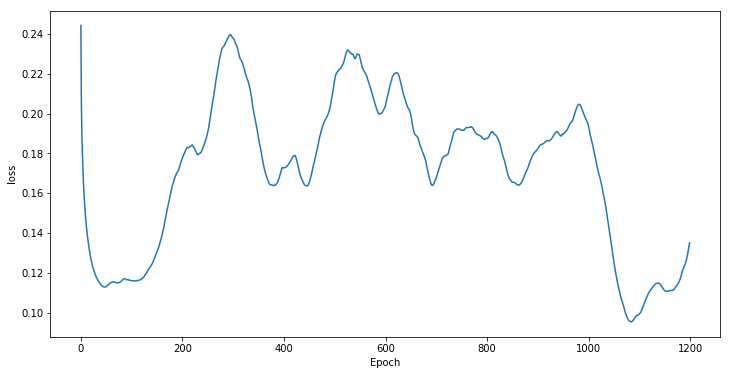

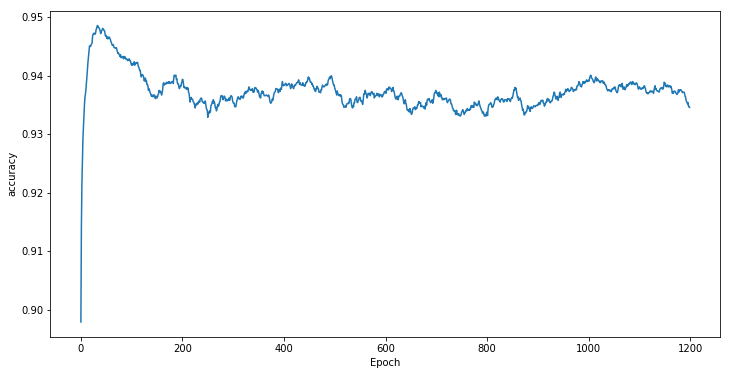

In [13]:
draw(loss_list, "loss")
draw(accuracy_list, "accuracy")

In [23]:
print("training loss 最小值: {:.3f}".format(min(loss_list)))
print("testing accuracy 最大值: {:.3f}".format(max(accuracy_list)))

training loss 最小值: 0.096
testing accuracy 最大值: 0.949
